##Use a GPU enabled runtime

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import statsmodels.tsa.seasonal as tsas

from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
from IPython.display import set_matplotlib_formats, display

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

sns.set(rc={"figure.dpi":90, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

<ipython-input-1-fd8d7d966962>:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [ ]:
!unrar x -Y '/content/Saved STS Models.rar' '/content/'

### Helpers

In [3]:
def transform(mean=0., std=1., inverse=False, offset=0.01):
    bijector = tfp.bijectors.Softplus()
    def method(X):
        if inverse:
            X = (X * std) + mean
            X = bijector.forward(X) - offset
        else:
            X = bijector.inverse(X + offset)
            X = (X - mean) / std
        return X
    return method

def load_dataset(path, sheet):
    df = pd.ExcelFile(path)
    df = pd.read_excel(df, sheet, parse_dates=True, index_col=0,)
    df.dropna(how='any', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    return df

def metrics(y_test, y_pred, idx_valid):
    metric_test = tf.gather(y_test.values, tf.where(idx_valid))
    metric_pred = tf.gather(y_pred, tf.where(idx_valid))
    MSLE = tf.keras.losses.MeanSquaredLogarithmicError()(metric_test, metric_pred)
    offset = tf.reduce_mean(metric_test)
    MAPE_test = metric_test + offset
    MAPE_pred = metric_pred + offset
    MAPE = np.mean(np.abs((MAPE_test - MAPE_pred) / MAPE_test)) * 100
    return MSLE, MAPE

### Load Dataset

In [23]:
PATH = '/content/data-updated.xlsx'
# Sheet 11 is used instead of Sheet 10 for Covid-19 Daily Cases
SHEET = 'Sheet13'

Dataset = load_dataset(PATH, SHEET).astype('float32')
p = 0.90 if SHEET in ['Sheet11'] else 0.8
N_train = int(0.8 * Dataset.shape[0])
Dataset_train, Dataset_test = Dataset[:N_train], Dataset[N_train:]
mean, std = Dataset.mean().values, Dataset.std().values
Dataset_train = tfp.sts.regularize_series(Dataset_train)
Dataset_test = tfp.sts.regularize_series(Dataset_test)
X_train = tf.math.round(Dataset_train.values)
X_train = transform(mean, std)(X_train)
X_train = tf.cast(tf.reshape(X_train, [-1]), tf.float32)
X_test = Dataset_test[Dataset.columns[0]]

### Plot Dataset

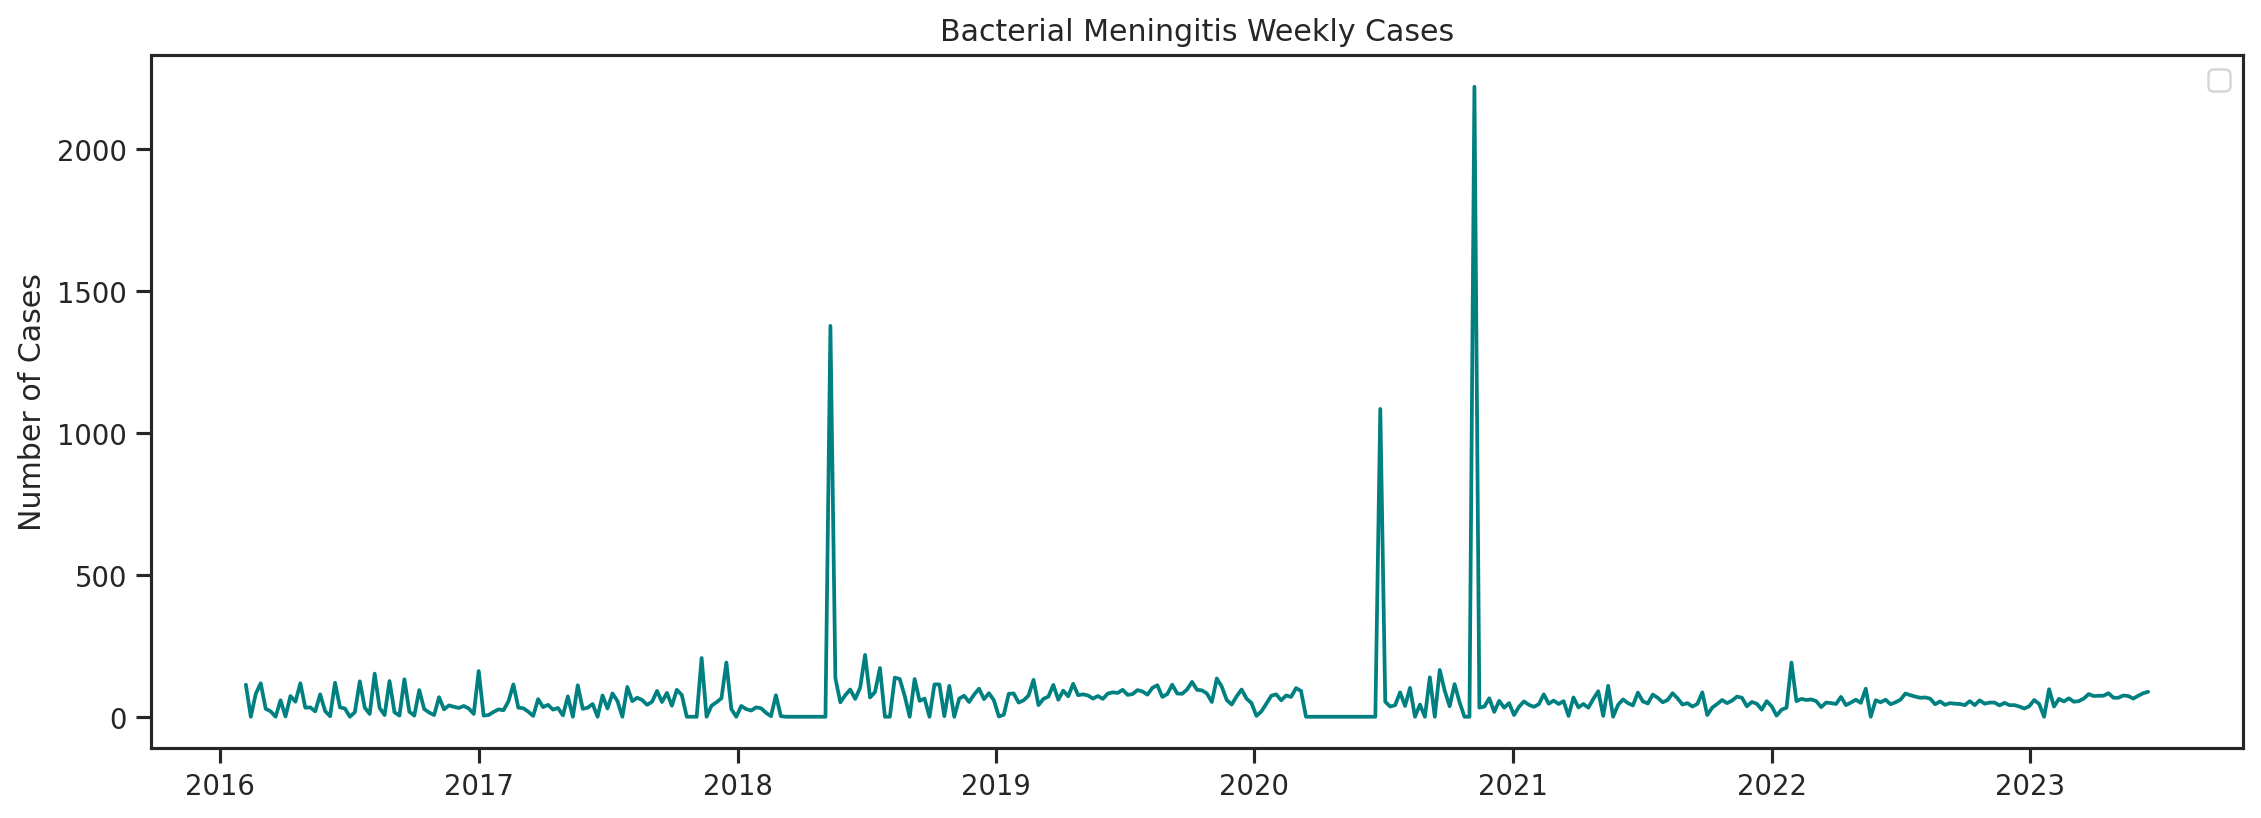

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(Dataset, color='teal')
ax.set_ylabel('Number of Cases')
ax.set_title(f'{Dataset.columns[0]} Weekly Cases')
ax.legend(loc='upper right')
plt.savefig(f'{Dataset.columns[0]}.svg')
plt.show()

### Plot Dataset Seasonal and Residual Components

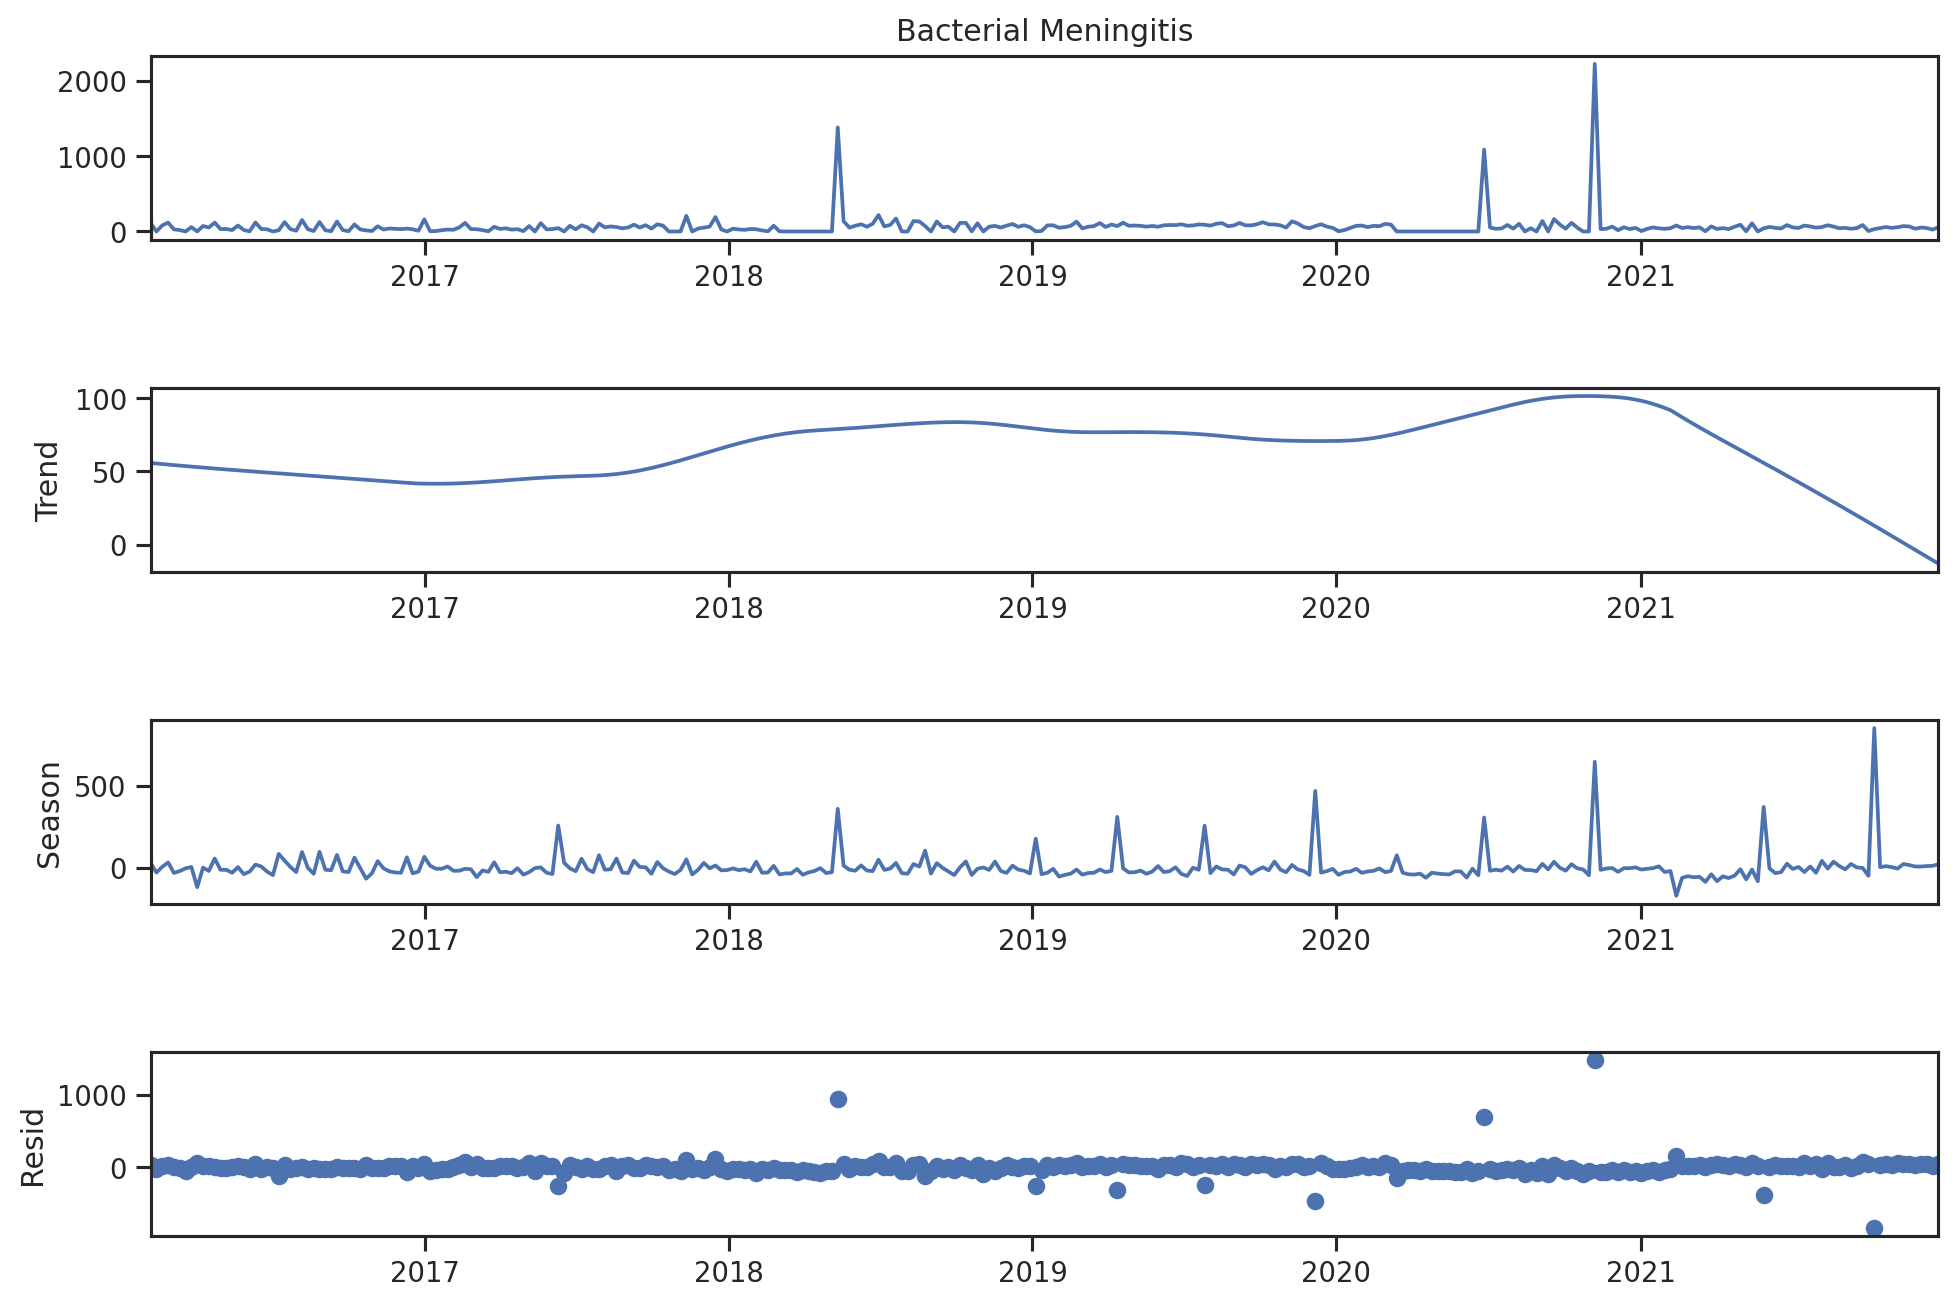

In [25]:
multiplier = 30 if Dataset.columns[0] == 'Covid-19' else 4
fig = tsas.STL(Dataset[:N_train][Dataset.columns[0]], period=multiplier*12).fit().plot()
fig.tight_layout()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.savefig(f'Decomp_{Dataset.columns[0]}.svg')

### Build STS Component

Run this for every change in disease group

In [26]:
def STS_components(group, y):
    group_week_of_year = ['Bacterial Meningitis', 'Rotavirus', 'Dengue']
    group_month_of_year = ['Chikungunya', 'Typhoid Fever', 'Cholera', 'Leptospirosis', 'Hepatitis A', 'Influenza-like illness', 'Acute bloody diarrhea']
    group_long_seasonal_trend = ['Dengue']
    group_local_linear = ['Measles']
    group_yearly_trend = ['Rotavirus', 'Chikungunya', 'Typhoid Fever', 'Hepatitis A', 'Cholera', 'Leptospirosis', 'Influenza-like illness', 'Acute bloody diarrhea']
    group_AR1_MA1 = ['Bacterial Meningitis', 'Covid-19', 'Dengue', 'Typhoid Fever', 'Measles']
    group_AR1 = ['Rotavirus', 'Cholera', 'Chikungunya', 'Leptospirosis', 'Influenza-like illness', 'Acute bloody diarrhea', 'Hepatitis A']
    components = []
    if group == 'Covid-19':
        components = [
            tfp.sts.SmoothSeasonal(
                period=360,
                frequency_multipliers=[c for c in range(10)],
                allow_drift=True,
                observed_time_series=y,
                name='sts_seasonal_1'),
            tfp.sts.Seasonal(
                num_seasons=140,
                allow_drift=True,
                observed_time_series=y,
                name='sts_seasonal_2'),
            tfp.sts.Seasonal(
                num_seasons=116,
                allow_drift=True,
                observed_time_series=y,
                name='sts_seasonal_3')]
    if group in group_week_of_year: components.append(tfp.sts.Seasonal(
            num_seasons=12*4,
            observed_time_series=y,
            allow_drift=True,
            name='sts_week_of_year'))
    if group in group_month_of_year: components.append(tfp.sts.Seasonal(
            num_seasons=12,
            num_steps_per_season=4,
            observed_time_series=y,
            allow_drift=True,
            name='sts_month_of_year'))
    if group in group_long_seasonal_trend: components.append(tfp.sts.Seasonal(
            num_seasons=int(4*12*(3.25)),
            allow_drift=True,
            observed_time_series=y,
            name='sts_long_seasonal_trend'))
    if group in group_local_linear: components.append(tfp.sts.LocalLinearTrend(
            observed_time_series=y,
            name='sts_local_trend'))
    if group in group_yearly_trend: components.append(tfp.sts.SmoothSeasonal(
            period=int(4*12*(1)),
            frequency_multipliers=[c for c in range(10)],
            allow_drift=True,
            observed_time_series=y,
            name='sts_yearly_trend'))
    if group in group_AR1_MA1: components.append(tfp.sts.AutoregressiveIntegratedMovingAverage(
            ar_order=1,
            ma_order=1,
            observed_time_series=y,
            name='sts_residuals'))
    if group in group_AR1: components.append(tfp.sts.Autoregressive(
            order=1,
            observed_time_series=y,
            name='sts_AR'))
    return components

components = STS_components(Dataset.columns[0], X_train)
model = tfp.sts.Sum(components=components, observed_time_series=X_train)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

In [27]:
for c in components:
    print(c)

### Plot Forecasts

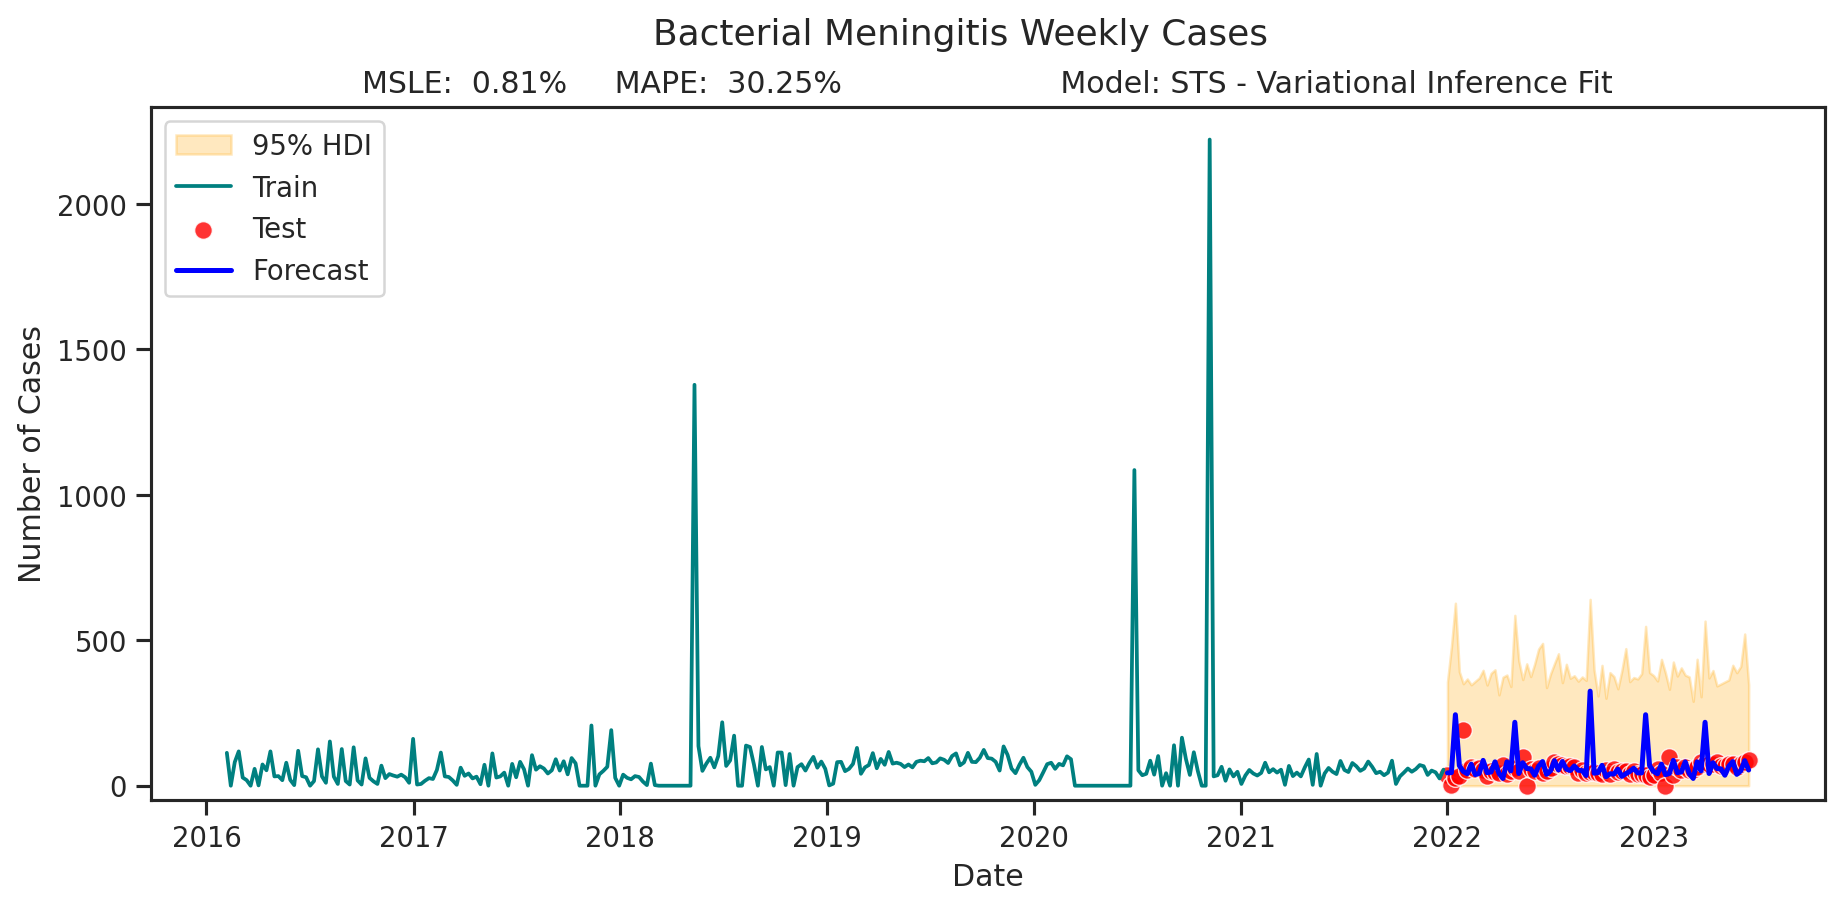

In [28]:
m2 = tf.Module()
m2.posterior_variable = variational_posteriors.variables
checkpoint = tf.train.Checkpoint(posterior=m2)
checkpoint.read(f'/content/Saved STS Models/{Dataset.columns[0]}/model').assert_consumed()

inverse_transform = transform(mean, std, inverse=True)
parameter_samples = variational_posteriors.sample(100)
idx_valid = 1 - pd.isnull(Dataset_test).any(axis=1).values

forecast_distribution = tfp.sts.forecast(
    model,
    observed_time_series=X_train,
    parameter_samples=parameter_samples,
    num_steps_forecast=len(Dataset_test))

forecast = (
    forecast_distribution.mean().numpy()[..., 0],
    forecast_distribution.stddev().numpy()[..., 0])

forecast_mean = tf.math.round(inverse_transform(forecast[0]))
forecast_scale = transform(0., std, inverse=True)(forecast[1])
forecast_samples = forecast_distribution.sample(150)
HDI = inverse_transform(az.hdi(forecast_samples[None, ...].numpy(), hdi_prob=0.95))

MSLE, MAPE = metrics(X_test, forecast_mean, idx_valid)

fig, ax = plt.subplots(figsize=(12, 5))
t = np.array(Dataset_test.index.to_pydatetime(), dtype=np.datetime64)
plt.fill_between(t,
                 HDI[..., 0, 0],
                 HDI[..., 0, 1],
                 color='orange', alpha=0.25, label='95% HDI')
ax.plot(Dataset_train, color='teal', linewidth=1.5, label='Train')
sns.scatterplot(X_test, color='red', label='Test', s=50, alpha=0.8)
ax.plot(Dataset_test.index, forecast_mean, color='blue', linewidth=2, label='Forecast')
ax.set_ylabel('Number of Cases'); ax.set_xlabel('Date')
ax.set_title(f'MSLE:  {MSLE :3.2f}%     MAPE:  {MAPE :3.2f}%                       Model: STS - Variational Inference Fit')
fig.suptitle(f'{Dataset.columns[0]} Weekly Cases')
ax.legend(loc='upper left')
ax.set_ylim([-50, Dataset.max().values + 0.05 * Dataset.max().values]);
plt.savefig(f'Forecast_{Dataset.columns[0]}.svg')
plt.show()

### Visualize Posterior Samples and Seasonal Effects

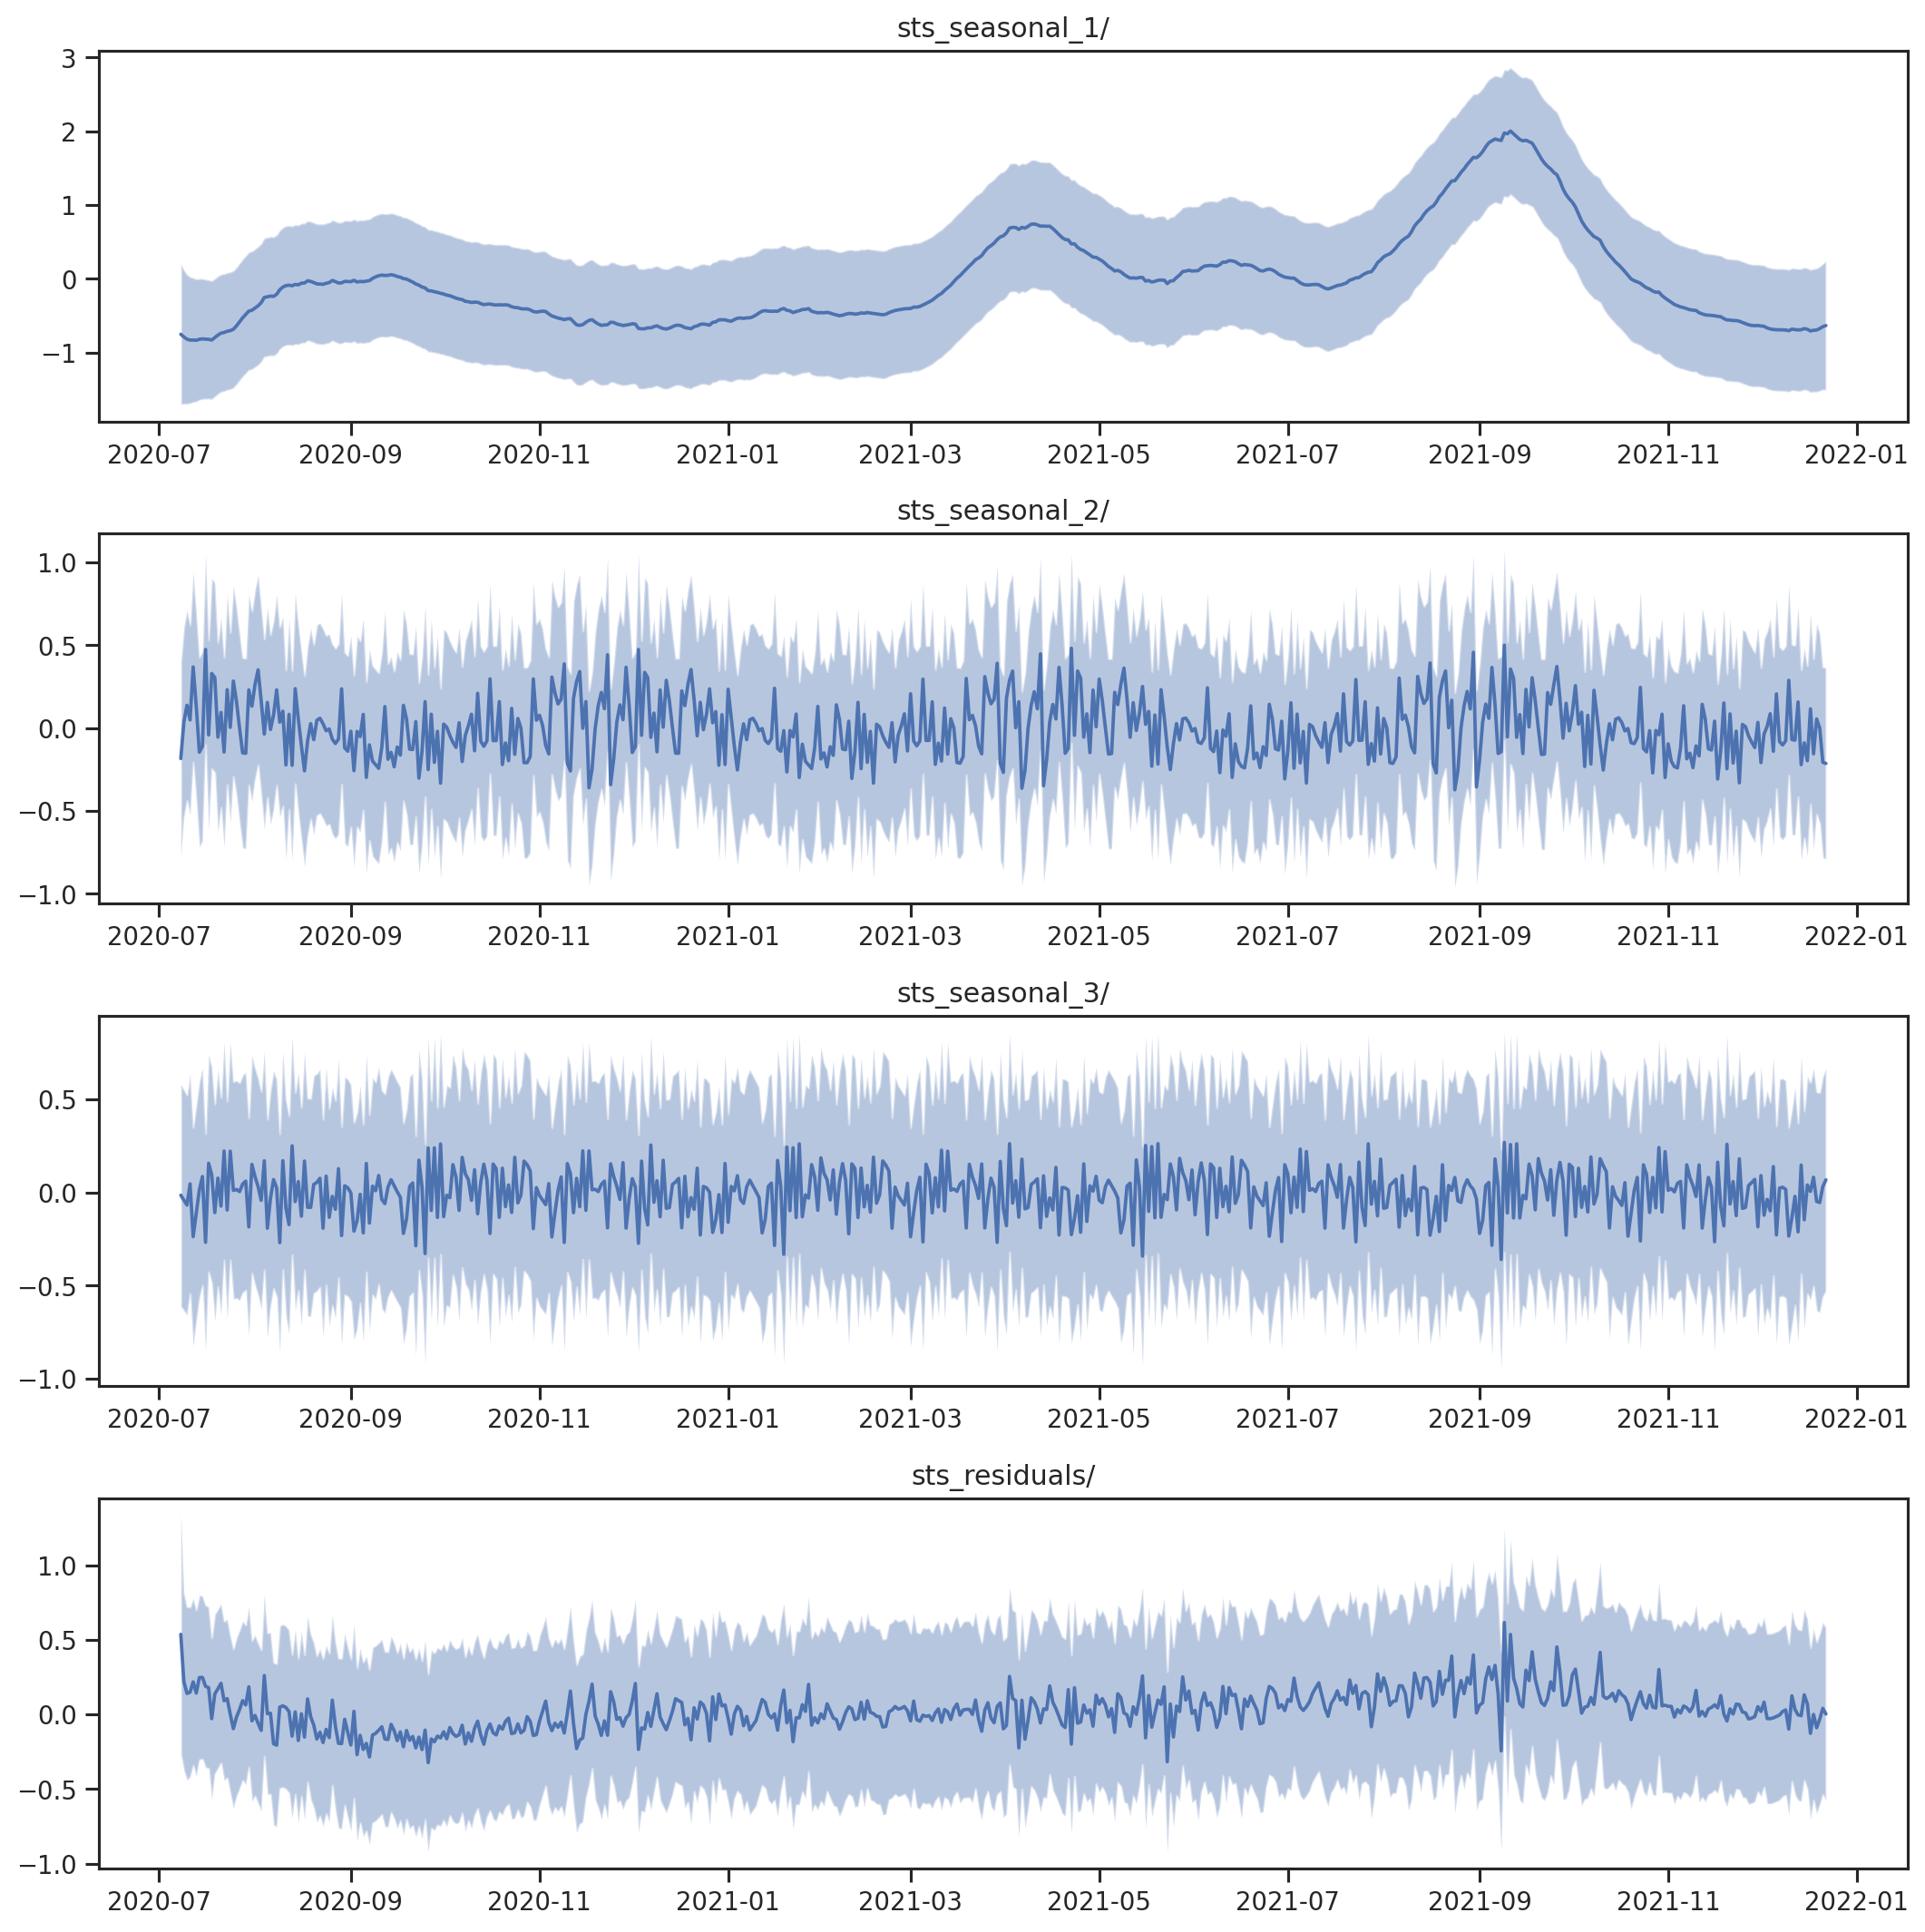

In [ ]:
parameter_samples = variational_posteriors.sample(15)
component_dists = tfp.sts.decompose_by_component(
    model=model,
    observed_time_series=X_train,
    parameter_samples=parameter_samples)
component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})
num_components = len(component_means)
fig, ax = plt.subplots(num_components, 1, figsize= (12, 12))
for i, component_name in enumerate(component_means.keys()):
    component_mean = component_means[component_name]
    component_stddev = component_stddevs[component_name]

    ax[i].plot(Dataset_train.index.values, component_mean)

    ax[i].fill_between(
        x=Dataset_train.index.values,
        y1=component_mean - 2*component_stddev,
        y2=component_mean + 2*component_stddev,
        alpha=0.4
    )
    ax[i].set(title=component_name)
plt.savefig(f'STS_{Dataset.columns[0]}.svg')
plt.tight_layout()
plt.show()

### Extra

In [ ]:
from scipy import signal

f, Pxx_den = signal.periodogram(
    x=Dataset[:N_train]['Covid-19'],
    detrend='linear',
    nfft=int(7e2)
)

fig, ax = plt.subplots()
sns.lineplot(x=f, y=Pxx_den, ax=ax)
ax.set(title='Power Spectral Density');

sort_freq_index = np.argsort(a=Pxx_den)[::-1]

periodogram_df = pd.DataFrame(
    {'sort_freq': f[sort_freq_index], 'Pxx_den': Pxx_den[sort_freq_index]}
)

periodogram_df.assign(days = lambda x: 1/x['sort_freq']).head(5)

In [ ]:
num_steps = 100
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(0.1, num_steps, alpha=0.0000001)
optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)

@tf.function
def fit():
    ELBO_loss = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_distribution(observed_time_series=X_train).log_prob,
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_steps)
    return ELBO_loss

ELBO_loss = fit()
plt.plot(ELBO_loss)
plt.ylabel('-ELBO');
plt.xlabel('Iteration')
plt.title(f'Training ELBO Loss - {Dataset.columns[0]}')
plt.savefig(f'Loss_{Dataset.columns[0]}.svg')
plt.show()